In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## PASCAL VOC data setup

In [2]:
# BASE_PATH = '/content/drive/MyDrive/ai/detection/detection-tutorial/'
BASE_PATH = '/content/drive/MyDrive/ai/detection/'

In [3]:
!ls {BASE_PATH}

detection-tutorial     faster_rcnn_model_0.pth	VOCtrainval_11-May-2012.tar
detectron2_test.ipynb  setup.ipynb


In [4]:
file = BASE_PATH + 'VOCtrainval_11-May-2012.tar'

In [5]:
%%time
!cp {file} .

CPU times: user 322 ms, sys: 61.5 ms, total: 384 ms
Wall time: 1min 11s


In [6]:
%%time
!tar -xvf ./VOCtrainval_11-May-2012.tar > /dev/null

CPU times: user 207 ms, sys: 33.8 ms, total: 241 ms
Wall time: 49.7 s


In [ ]:
!pwd

/content


In [ ]:
!ls

drive  sample_data  VOCdevkit  VOCtrainval_11-May-2012.tar


## Imports

In [1]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

In [9]:
os.chdir("drive/My Drive/ai/detection/detection-tutorial")
# os.chdir("/content/")

In [10]:
# import sys
# sys.path.append('./dataset/')
# sys.path.append('./')
# sys.path

In [14]:
from transforms import get_transform
from utils import format_time, seed_everything
from utils import generate_anchors, process_anchors, find_jaccard_overlap
from utils_plot import show_image_and_bb, show_anchors, show_image_from_dataset

from loss import BoxLoss
from train import run_loader, get_device

from faster_rcnn import faster_rcnn

In [ ]:
# !mkdir ./pascal-voc

mkdir: cannot create directory ‘./pascal-voc’: File exists


In [ ]:
# from dataset.pascal_voc_utils import create_data_lists
# create_data_lists(
#     voc07_path=None,
#     voc12_path='/content/VOCdevkit/VOC2012/',
#     # voc12_path='../VOCdevkit/VOC2012/',
#     output_folder='./pascal-voc/'
# )


There are 11540 training images containing a total of 34620 objects. Files have been saved to /content/drive/My Drive/ai/detection/detection-tutorial/pascal-voc.


In [15]:
SEED = 2021
seed_everything(SEED)

## PennFudanDataset

In [ ]:
from dataset.penn_fudan_dataset import PennFudanDataset

In [ ]:
# dataset = PennFudanDataset('../PennFudanPed', get_transform(train=False))
dataset = PennFudanDataset('../PennFudanPed', None)

In [ ]:
image, target = dataset[0]

In [ ]:
type(image)

PIL.Image.Image

In [ ]:
target

{'boxes': tensor([[159., 181., 301., 430.],
         [419., 170., 534., 485.]]),
 'labels': tensor([1, 1])}

tensor([159., 181., 301., 430.])
tensor([419., 170., 534., 485.])


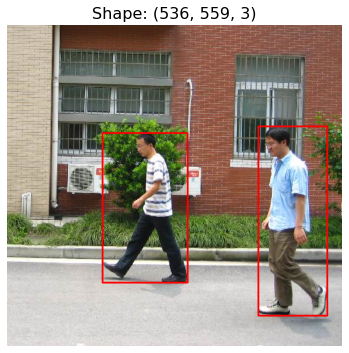

In [ ]:
# show_image(dataset, 0)
show_image_and_bb(image, target)

In [ ]:
anchors = generate_anchors()

In [ ]:
# anchors = anchors[:5]
anchors.shape

torch.Size([441, 4])

In [ ]:
# each anchor we need to match gt_box and binary label - positive
# or 0 label and no box - negative

# We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes.
# Anchors that are neither positive nor negative do not contribute to the training objective.

# + add delatas for loss

In [ ]:
anchor_labels, gt_offsets = process_anchors(anchors, target['boxes'])

In [ ]:
def get_top_n_anchors(anchors, gt_boxes):
    # anchors (N1, 4)
    # gt_boxes (N2, 4)
 
    jaccard = find_jaccard_overlap(anchors, gt_boxes) # (N1, N2)
    
    prior_max_iou, prior_gt_box_idx = jaccard.max(1) # (N1), (N1)
    
    top_n = 10
    _, top_priors_idx = prior_max_iou.sort(descending=True)
    return anchors[top_priors_idx[:top_n]], prior_max_iou[top_priors_idx[:top_n]]

In [ ]:
top_n_anchors, top_n_iou = get_top_n_anchors(anchors, target['boxes'])

In [ ]:
top_n_iou

tensor([0.4745, 0.4732, 0.4732, 0.4691, 0.4008, 0.3733, 0.3733, 0.3644, 0.3631,
        0.3602])

In [ ]:
N = 9
start = 24
# show_anchors(image, target['boxes'], anchors[start*N:(start+1)*N])
# show_anchors(image, target['boxes'], anchors)

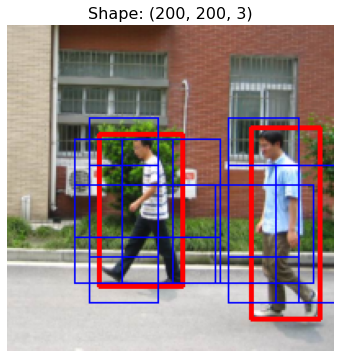

In [ ]:
show_anchors(image, target['boxes'], top_n_anchors)

## PASCAL VOC dataset

In [4]:
from dataset.pascal_voc_dataset import PascalVOCDataset

In [5]:
# dataset = PascalVOCDataset('/content/pascal-voc/', 'TRAIN', get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/', 'TRAIN', get_transform(train=True))

In [6]:
image, target = dataset[3]

/Users/michaelka/Developer/ml/projects/detection/detection-tutorial/dataset/pascal_voc_dataset.py:53: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  boxes = boxes[1 - difficulties]
/Users/michaelka/Developer/ml/projects/detection/detection-tutorial/dataset/pascal_voc_dataset.py:54: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  labels = labels[1 - difficulties]
/Users/michaelka/Developer/ml/projects/detection/detection-tutorial/dataset/pascal_voc_dataset.py:55: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  difficulties = difficulties[1 - difficulties]


In [7]:
target

{'boxes': tensor([[0.1040, 0.1946, 0.9400, 0.9480],
         [0.3140, 0.0973, 0.5760, 0.3756]]),
 'labels': tensor([13, 15]),
 'difficulties': tensor([0, 0], dtype=torch.uint8)}

tensor([ 20.8000,  38.9140, 188.0000, 189.5928])
tensor([ 62.8000,  19.4570, 115.2000,  75.1131])
Shape: (200, 200, 3)


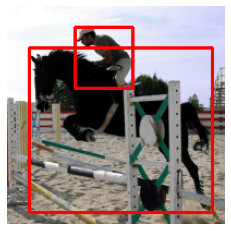

In [8]:
# plt.figure(figsize=(6,6))
show_image_and_bb(image, target['boxes'])

## Model single path

In [ ]:
device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
def collate_fn(batch):
    # batch: list[tuple]
    # each tuple is (image, target) dictionary
    # turns it into a single tuple (in this case of len == 2)
    
    # TODO: why it's always tuple  
    # print(f'collate_fn, {len(batch)}, {list(zip(*batch))[0]}, {type(list(zip(*batch))[0])}')
    # return list(zip(*batch))
    
    # torch.stack here? for images?
    # do we distinguish targets between images?
    
    return tuple(zip(*batch))

In [ ]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [ ]:
images, targets = next(iter(data_loader))
type(images), type(targets)

/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:53: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  boxes = boxes[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:54: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  labels = labels[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:55: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  difficulties = difficulties[1 - difficulties]


(tuple, tuple)

In [ ]:
images = torch.stack(images, dim=0).to(device)
images.shape

torch.Size([8, 3, 200, 200])

In [ ]:
# targets

In [ ]:
net = faster_rcnn().to(device)

In [ ]:
offsets, labels = net(images)
offsets.shape, labels.shape

(torch.Size([8, 441, 4]), torch.Size([8, 441, 1]))

In [ ]:
criterion = BoxLoss(device)

In [ ]:
loss = criterion(labels, offsets, targets)

anchors pos: 550, neg: 2978
torch.Size([8, 441, 4])
torch.Size([8, 441])
torch.Size([550, 4])


In [ ]:
loss

(tensor(2.4960, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.8152, device='cuda:0', grad_fn=<L1LossBackward>),
 tensor(0.6807, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>))

In [ ]:
-np.log(1/2)

0.6931471805599453

In [ ]:
gt_labels, gt_offsets = criterion.process_target_batch(targets)

In [ ]:
gt_labels.shape

torch.Size([8, 441])

In [ ]:
torch.unique(torch.tensor([1,1,0,2]), return_counts=True)

(tensor([0, 1, 2]), tensor([1, 2, 1]))

## Train Model

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
len(train_loader)

1443

In [ ]:
params = {
    'learning_rate' : 0.001,
    'weight_decay'  : 0,
    'num_epoch'     : 2
}

model = faster_rcnn()

run_loader(model, train_loader, None, **params)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
[train] index:  0, loss(box/cls) = 2.51103(1.77640/0.73463) time: 0:00:00


/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:47: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  boxes = boxes[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:48: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  labels = labels[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:49: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  difficulties = difficulties[1 - difficulties]


[train] index: 100, loss(box/cls) = 2.08980(1.67377/0.41603) time: 0:00:07
[train] index: 200, loss(box/cls) = 1.53724(1.12103/0.41621) time: 0:00:14
[train] index: 300, loss(box/cls) = 1.54284(1.17414/0.36871) time: 0:00:20
[train] index: 400, loss(box/cls) = 1.33409(0.94387/0.39022) time: 0:00:27
[train] index: 500, loss(box/cls) = 1.23265(0.95894/0.27371) time: 0:00:34
[train] index: 600, loss(box/cls) = 1.47188(1.15760/0.31429) time: 0:00:41
[train] index: 700, loss(box/cls) = 1.38084(1.11081/0.27003) time: 0:00:48
[train] index: 800, loss(box/cls) = 1.13748(0.78485/0.35264) time: 0:00:54
[train] index: 900, loss(box/cls) = 1.44728(1.20427/0.24301) time: 0:01:01
[train] index: 1000, loss(box/cls) = 1.23932(0.86597/0.37335) time: 0:01:08
[train] index: 1100, loss(box/cls) = 0.96726(0.75159/0.21567) time: 0:01:14
[train] index: 1200, loss(box/cls) = 1.32545(1.02724/0.29821) time: 0:01:21
[train] index: 1300, loss(box/cls) = 1.23931(0.93166/0.30765) time: 0:01:28
[train] index: 1400, 

{}

## Run

In [ ]:
from train import main, run

In [ ]:
from utils_plot import show_loss_history, show_loss_epochs

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
# train_info = main(debug=True)

In [ ]:
model = faster_rcnn()

params = {
    'learning_rate' : 0.001,
    'weight_decay'  : 0,
    'batch_size'    : 8,
    'num_epoch'     : 5,
    'verbose'       : True,
    'debug'         : False
}

train_info = run(model, **params)

data size, all: 11540, train: 10386
data loader size, train: 1299, valid: 145, batch_size 8
learning_rate = 0.001
weight_decay = 0
num_epoch = 5

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
training started...
anchors pos: 533, neg: 2995


/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:53: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  boxes = boxes[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:54: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  labels = labels[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:55: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  difficulties = difficulties[1 - difficulties]


[train] index:  0, loss(box/cls) = 2.52759(1.85934/0.66825) time: 0:00:00
anchors pos: 668, neg: 2860
anchors pos: 786, neg: 2742
anchors pos: 814, neg: 2714
anchors pos: 387, neg: 3141
anchors pos: 672, neg: 2856
anchors pos: 593, neg: 2935
anchors pos: 459, neg: 3069
anchors pos: 867, neg: 2661
anchors pos: 346, neg: 3182
anchors pos: 451, neg: 3077
anchors pos: 810, neg: 2718
anchors pos: 926, neg: 2602
anchors pos: 695, neg: 2833
anchors pos: 731, neg: 2797
anchors pos: 629, neg: 2899
anchors pos: 575, neg: 2953
anchors pos: 582, neg: 2946
anchors pos: 666, neg: 2862
anchors pos: 613, neg: 2915
anchors pos: 1016, neg: 2512
anchors pos: 624, neg: 2904
anchors pos: 635, neg: 2893
anchors pos: 751, neg: 2777
anchors pos: 488, neg: 3040
anchors pos: 723, neg: 2805
anchors pos: 569, neg: 2959
anchors pos: 786, neg: 2742
anchors pos: 596, neg: 2932
anchors pos: 879, neg: 2649
anchors pos: 546, neg: 2982
anchors pos: 657, neg: 2871
anchors pos: 727, neg: 2801
anchors pos: 380, neg: 3148
a

KeyboardInterrupt: ignored

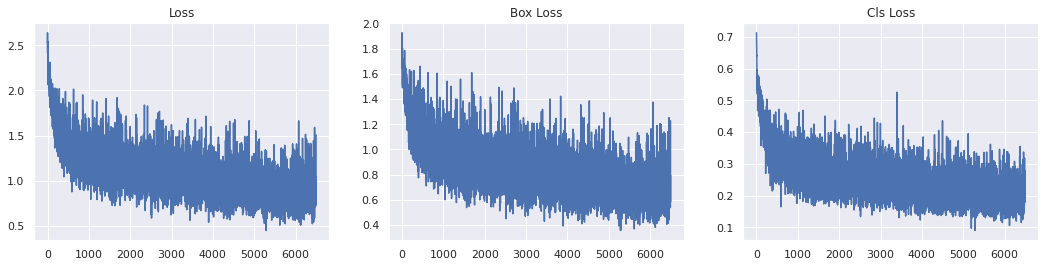

In [ ]:
show_loss_history(train_info)

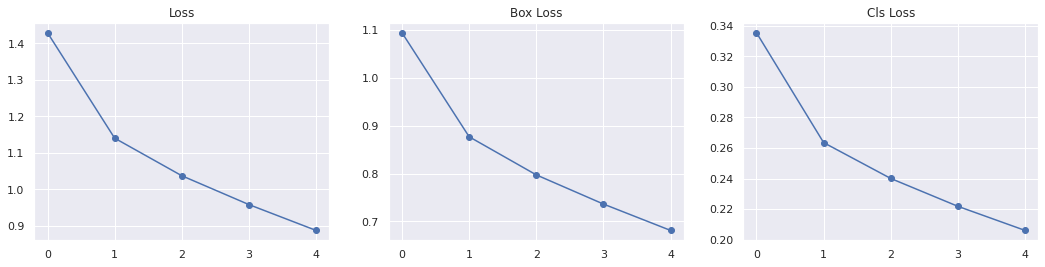

In [ ]:
show_loss_epochs(train_info)

In [ ]:
model_path = os.path.join(BASE_PATH, 'faster_rcnn_model_0.pth')
# torch.save(model.state_dict(), model_path)

## Show predictions

In [9]:
# model_path = os.path.join(BASE_PATH, 'faster_rcnn_model_0.pth')
model_path = '../pth/faster_rcnn_model_0.pth'

In [10]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from utils_plot import show_predictions

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
device = get_device()

No GPU available, using the CPU instead.


In [174]:
train_number = 10386
all_number = 11540

valid_sampler = SubsetRandomSampler(range(train_number, all_number))
valid_loader = DataLoader(
    dataset,
    batch_size=8,
    sampler=valid_sampler,
    num_workers=0,
    collate_fn=collate_fn
)

len(valid_loader)

145

In [17]:
images, targets = next(iter(valid_loader))

In [18]:
images = torch.stack(images, dim=0).to(device)

In [21]:
model = faster_rcnn(device)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
# model.load_state_dict(torch.load(model_path))
model.eval()
print('')

In [22]:
offsets, labels = model(images)

In [23]:
images.shape, offsets.shape, labels.shape

(torch.Size([8, 3, 200, 200]),
 torch.Size([8, 441, 4]),
 torch.Size([8, 441, 1]))

In [51]:
pred_boxes, pred_conf = model.detect(offsets, labels, prob_threshold=0.5, max_overlap=0.7)

8
[FasterRCNN] num_positives: 18
[FasterRCNN] num_positives: 23
[FasterRCNN] num_positives: 131
[FasterRCNN] num_positives: 0
[FasterRCNN] num_positives: 105
[FasterRCNN] num_positives: 141
[FasterRCNN] num_positives: 56
[FasterRCNN] num_positives: 106


In [56]:
# targets

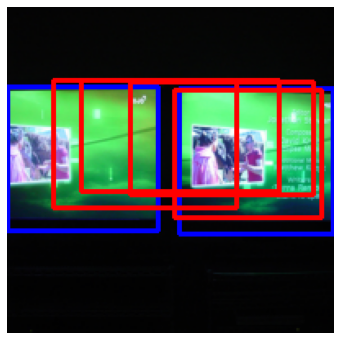

In [48]:
plt.figure(figsize=(6,6))
image_index = 1
gt_boxes = targets[image_index]['boxes']
final_boxes = predicted_boxes[image_index].cpu()
show_predictions(images[image_index], gt_boxes, final_boxes, verbose=False)
# show_image_and_bb(image, torch.tensor([[0,0,0.1,0.1]], dtype=torch.float), verbose=False)

## Evaluation

In [162]:
from utils import calculate_mAP

In [163]:
det_boxes = pred_boxes
det_scores = pred_conf
true_boxes = [t['boxes'] for t in targets]
true_labels = [t['labels'] for t in targets]

In [164]:
calculate_mAP(pred_boxes, pred_conf, true_boxes, true_labels, device)

tensor(0.6667)

In [167]:
from train import validate

In [168]:
criterion = BoxLoss(device)

In [176]:
train_number = 10500
all_number = 11000

valid_sampler = SubsetRandomSampler(range(train_number, all_number))
valid_loader = DataLoader(
    dataset,
    batch_size=8,
    sampler=valid_sampler,
    num_workers=0,
    collate_fn=collate_fn
)

len(valid_loader)

63

In [177]:
loss_meters, mAP = validate(model, device, criterion, valid_loader)

[valid] index:  0, loss(box/cls) = 1.51952(1.14207/0.37745) time: 0:00:01
[valid] index: 20, loss(box/cls) = 1.10184(0.85093/0.25092) time: 0:00:15
[valid] index: 40, loss(box/cls) = 1.06123(0.82178/0.23945) time: 0:00:30
[valid] index: 60, loss(box/cls) = 1.06220(0.82424/0.23796) time: 0:00:44
[valid] calculate_mAP... time: 0:00:46
[valid] finished! time: 0:00:46


In [179]:
mAP

tensor(0.2877)

## ipywidgets

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [ ]:
# dataset = PascalVOCDataset('./pascal-voc/', transforms=get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/')

get_transform_to_show


In [ ]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(dataset),
    step=1,
    description='Image:',
    disabled=False
)

def handle_change(x):
    print(x)
    show_image_from_dataset(dataset, x, top_n_anchors=0)

In [ ]:
# do it only once

# import json
# # with open('./pascal-voc/label_map.json'), 'r') as j:
# data_folder = './pascal-voc'
# with open(os.path.join(data_folder, 'label_map.json'), 'r') as j:
#     labels = json.load(j)

In [ ]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Image:', max=11540), Output()), _dom_classes=('widg…

<function __main__.handle_change(x)>

## Trainimg